In [114]:
%matplotlib ipympl

In [115]:
from impedance.models.circuits import CustomCircuit
from impedance.models.circuits.elements import element
import numpy as np
import scipy
import matplotlib.pyplot as plt
from impedance.visualization import plot_nyquist, plot_bode

In [116]:
#My written functions
def add_noise(z,err):
    #err is the relative SD from mean value
    z_with_noise=np.random.normal(np.real(z),err*np.abs(np.real(z)))+1j*np.random.normal(np.imag(z),err*np.abs(np.imag(z)))
    return z_with_noise

def give_weights(z,wt):
    if (wt=="mod"):
        return np.concatenate((np.abs(z),np.abs(z)))
    elif (wt=="prop"):
        return np.concatenate((np.real(z),np.imag(z)))
    elif (wt=="" or wt=="unit"):
        return np.ones(2*len(z))

def give_xylim(zin,z0):
        zin_real=np.real(zin)
        zin_imag=np.imag(zin)

        z0_real=np.real(z0)
        z0_imag=np.imag(z0)

        max_0=np.maximum(np.max(z0_real),np.max(-z0_imag))
        max_in=np.maximum(np.max(zin_real),np.max(-zin_imag))

        xylim=np.maximum(max_0,max_in)
        return xylim

def find_index_of_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [117]:
@element(num_params=7, units=["Ohm", "Ohm", "Ohm", "","", "F",""],overwrite=True)
def TLMthreeNew(p, f):
    omega = 2 * np.pi * np.array(f)
    R1, R2, R3, delta1, delta2, Q, alpha = p[0], p[1], p[2],p[3], p[4], p[5], p[6]
    delta3=1-delta1-delta2
    k12=R2/R1
    k13=R3/R1
    Rion1=R1
    Rion2=R2
    Rion3=R3
    CTotal1=Q
    CTotal2=Q
    CTotal3=Q
    wc1=1/(Rion1*CTotal1)
    wc2=1/(Rion2*CTotal2)
    wc3=1/(Rion3*CTotal3)
    S1=np.sqrt((omega*1j)**alpha/wc1)
    S2=np.sqrt((omega*1j)**alpha/wc2)
    S3=np.sqrt((omega*1j)**alpha/wc3)
    C1=1/np.tanh(delta1*S1)
    C2=1/np.tanh(delta2*S2)
    C3=1/np.tanh(delta3*S3)

    Z=2*(R1)*((S1*S3*C1*k12**2+S2*C2*(S1*C1*C3*k13+S3)*k12+S2**2*C3*k13)/(S1*(S3*S1*k12**2+S2*C2*(S3*C1+S1*C3*k13)*k12+S2**2*C1*C3*k13)))
    
    return Z

In [118]:
c0=CustomCircuit(initial_guess=[1000,100,500,0.12,0.17,1e-4,1],circuit='TLMthreeNew')
freq = np.logspace(4,-3,num=50)
z0 = c0.predict(freq)
#z1=add_noise(z0,0.05)

In [119]:
param_guess=[1000,100,500,0.12,0.17,1e-4,0.9]
cg=CustomCircuit(initial_guess=param_guess,circuit='TLMthreeNew')
fit1=cg.fit(freq,z0,sigma=give_weights(z0,"mod"),bounds=(0,[np.inf,np.inf,np.inf,1,1,np.inf,1]))
zfit1=fit1.predict(freq)



Circuit string: TLMthreeNew
Fit: True

Initial guesses:
  TLMthreeNew_0 = 1.00e+03 [Ohm]
  TLMthreeNew_1 = 1.00e+02 [Ohm]
  TLMthreeNew_2 = 5.00e+02 [Ohm]
  TLMthreeNew_3 = 1.20e-01 []
  TLMthreeNew_4 = 1.70e-01 []
  TLMthreeNew_5 = 1.00e-04 [F]
  TLMthreeNew_6 = 9.00e-01 []

Fit parameters:
  TLMthreeNew_0 = 1.00e+03  (+/- 8.50e-04) [Ohm]
  TLMthreeNew_1 = 1.00e+02  (+/- 1.72e-02) [Ohm]
  TLMthreeNew_2 = 5.00e+02  (+/- 3.27e-03) [Ohm]
  TLMthreeNew_3 = 1.20e-01  (+/- 1.30e-06) []
  TLMthreeNew_4 = 1.70e-01  (+/- 7.61e-06) []
  TLMthreeNew_5 = 1.00e-04  (+/- 2.03e-11) [F]
  TLMthreeNew_6 = 1.00e+00  (+/- 6.60e-08) []



(0.0, 1059.6791995818403)

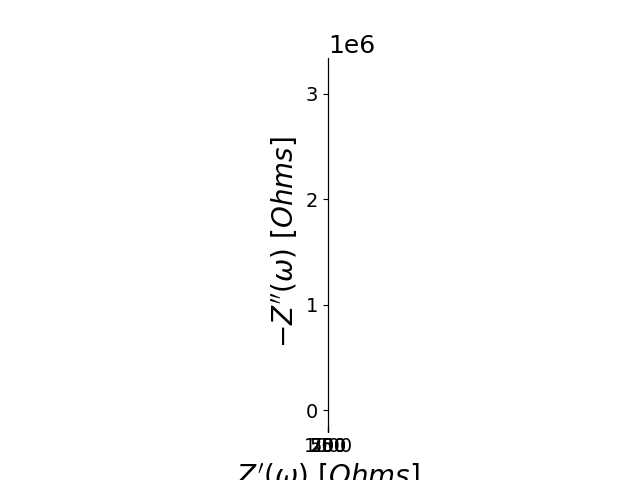

No such comm: 26e277d9b4e141f09770dadedc563863


In [120]:
print(fit1)
fig, ax=plt.subplots()
plot_nyquist(zfit1,ax=ax)
plot_nyquist(z0,ax=ax)
ax.set_xlim(0,3*np.maximum(np.max(np.real(z0)),np.max(np.imag(z0))))

In [125]:
def plotter_for_three(freq,circuit0,zin,circuitg,wt):
    
    c0=circuit0
    z0=c0.predict(freq)
    
    cg=circuitg
    cf=cg.fit(freq,zin,sigma=give_weights(zin,wt),bounds=(0,[np.inf,np.inf,np.inf,1,1,np.inf,1]))
    zf=cf.predict(freq)

    p0=c0.initial_guess
    R1_0, R2_0, R3_0, delta1_0, delta2_0, Q_0, alpha_0 = p0[0], p0[1], p0[2],p0[3], p0[4], p0[5], p0[6]

    pf=cf.parameters_
    R1_f, R2_f, R3_f, delta1_f, delta2_f, Q_f, alpha_f = pf[0], pf[1], pf[2],pf[3], pf[4], pf[5], pf[6]

    linewidth=1
    ticksize=6
    color_actual="green"
    color_noise="red"
    color_fitted="blue"

    fig = plt.figure(f"Results at δ1={delta1_0} and δ2={delta2_0}")
    fig.set_size_inches(10,6)
    
    #profile fit and profile original
    ax1= fig.add_subplot(2,3,2)
    ax1.plot([0,delta1_0,delta1_0,delta2_0,delta2_0,1],[R1_0,R1_0,R2_0,R2_0,R3_0,R3_0],linewidth=linewidth,color=color_actual,label="Actual")
    ax1.plot([0,delta1_f,delta1_f,delta2_f,delta2_f,1],[R1_f,R1_f,R2_f,R2_f,R3_f,R3_f],linewidth=linewidth,color=color_fitted,label="Fitted")
    ax1.tick_params(labelsize=ticksize)
    ax1.axvline(x=delta1_0,ls="--",linewidth=0.6,color=color_actual)
    ax1.axvline(x=delta2_0,ls="--",linewidth=0.6,color=color_actual)
    ax1.axvline(x=delta1_f,ls="--",linewidth=0.6,color=color_fitted)
    ax1.axvline(x=delta2_f,ls="--",linewidth=0.6,color=color_fitted)
    ax1.set_ylabel("R1 / R2 / R3 (Ω)")
    ax1.set_xlabel("δ")
    ax1.set_xmargin(0)
    ax1.legend()

    xylim=max(give_xylim(zin,zf),give_xylim(zin,z0))

    if xylim%1000>=1:
        units="kΩ"
        factor=1000
    else:
        units="Ω"
        factor=1

    #nyquist plot 
    ax2=fig.add_subplot(2,3,3)
    ax2.set_xlim(-0.2*xylim/factor,xylim/factor)
    ax2.set_ylim(-0.2*xylim/factor,xylim/factor)
    plot_nyquist(z0/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(zin/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise,ms=2,ticksize=ticksize)
    plot_nyquist(zf/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted,linewidth=linewidth,ticksize=ticksize)
    #inset_for_nyquist_plot
    ax2_inset=ax2.inset_axes(bounds=[0.4,0.4,0.5,0.5])
    plot_nyquist(z0/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(zin/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise,ms=2,ticksize=ticksize)
    plot_nyquist(zf/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_fitted,linewidth=linewidth,ticksize=ticksize)    

    f_c=1/(R1_0*Q_0)
    idx=find_index_of_nearest(freq,f_c)
    z_c=c0.predict([freq[idx]])

    xylim=np.real(1.2*np.real(z_c))
    ax2_inset.set_xlim(0,xylim/factor)
    ax2_inset.set_ylim(0,xylim/factor)
    ax2_inset.set_xlabel("")
    ax2_inset.set_ylabel("")
    ax2.indicate_inset_zoom(ax2_inset)

    #bode plots
    ax3a=fig.add_subplot(2,3,5)
    ax3b=fig.add_subplot(2,3,6)
    plot_bode(freq,z0/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,zin/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise,ms=2,ticksize=ticksize)
    plot_bode(freq,zf/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted,linewidth=linewidth,ticksize=ticksize)


    pf[0]=np.around(pf[0],decimals=0,out=None)
    pf[1]=np.around(pf[1],decimals=0,out=None)
    pf[2]=np.around(pf[2],decimals=0,out=None)
    pf[3]=np.around(pf[3],decimals=3,out=None)
    pf[4]=np.around(pf[4],decimals=3,out=None)
    pf[5]=np.around(pf[5],decimals=6,out=None)
    pf[6]=np.around(pf[6],decimals=3,out=None)

    p0[0]=np.around(p0[0],decimals=0,out=None)
    p0[1]=np.around(p0[1],decimals=0,out=None)
    p0[2]=np.around(p0[2],decimals=0,out=None)
    p0[3]=np.around(p0[3],decimals=3,out=None)
    p0[4]=np.around(pf[4],decimals=3,out=None)
    p0[5]=np.around(pf[5],decimals=6,out=None)
    p0[6]=np.around(pf[6],decimals=3,out=None)

    data =np.array([p0,pf, (p0-pf)*100/(p0)])
    #cell_colors=[["blue","blue","blue","blue"],["green","green","green","green"]]
    
    
    ax4=fig.add_subplot(1,3,1)
    ax4.set_axis_off()
    pm_table=ax4.table(np.transpose(data),colLabels=["Actual","Fitted","% Error"],rowLabels=["R1","R2","R3","δ1","δ2","Q","α"],loc="center")
    pm_table.auto_set_font_size(False)
    pm_table.set_fontsize(10)
    plt.savefig("ggg.png")

    

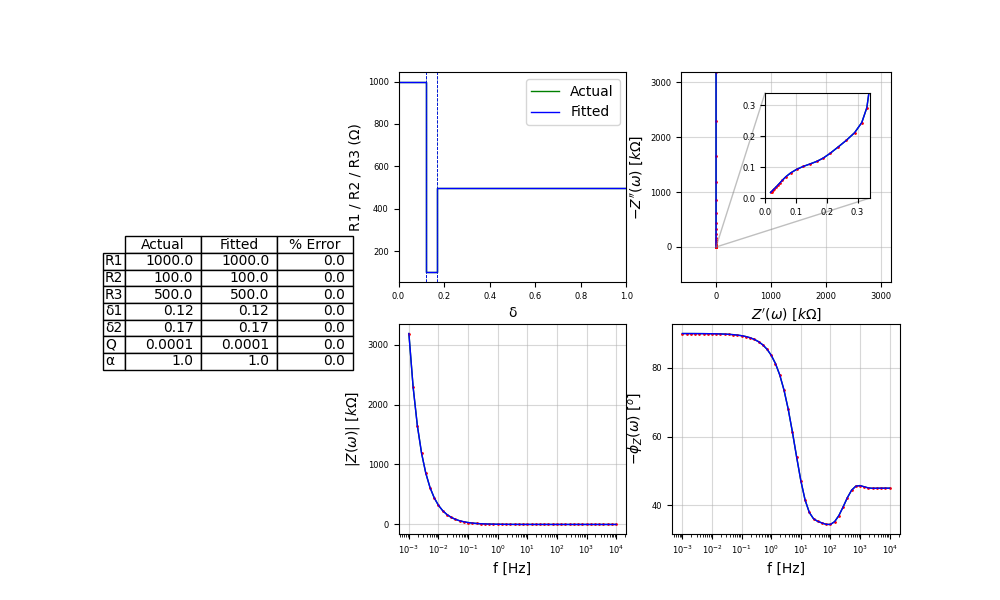

In [126]:
plt.close()
plotter_for_three(freq=freq,circuit0=c0,zin=z0,circuitg=cg,wt="mod")
plt.show()